In [87]:
import xarray as xr
import numpy as np

import interpolation

%watermark -mdp numpy,xarray,matplotlib,sdf

2018-06-10 

numpy 1.14.3
xarray 0.10.7
matplotlib 2.2.2
sdf 0.3.3

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


In [88]:
arr = xr.DataArray(np.sort(np.sort(np.random.RandomState(123).rand(30,20), axis=0), axis=1),
                   coords=[('tension', np.arange(10, 40)),
                           ('resistance', np.linspace(100, 500, 20))])
arr

<xarray.DataArray (tension: 30, resistance: 20)>
array([[8.188761e-05, 2.688065e-03, 3.532211e-03, ..., 5.893948e-02,
        7.914896e-02, 8.482228e-02],
       [5.545408e-03, 1.612921e-02, 2.524236e-02, ..., 1.059085e-01,
        1.655600e-01, 1.710818e-01],
       [1.639248e-02, 2.754293e-02, 2.931972e-02, ..., 1.269580e-01,
        1.942230e-01, 2.326864e-01],
       ...,
       [7.922993e-01, 8.327162e-01, 8.524495e-01, ..., 9.710461e-01,
        9.826226e-01, 9.883285e-01],
       [8.040264e-01, 8.754568e-01, 8.827130e-01, ..., 9.835216e-01,
        9.882149e-01, 9.924784e-01],
       [9.121321e-01, 9.251325e-01, 9.319321e-01, ..., 9.953585e-01,
        9.960863e-01, 9.989184e-01]])
Coordinates:
  * tension     (tension) int64 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 ...
  * resistance  (resistance) float64 100.0 121.1 142.1 163.2 184.2 205.3 ...

In [89]:
%timeit arr.interpolate(10.2, 120.4)

926 µs ± 106 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [90]:
%timeit arr.interp({'tension': 10.2, 'resistance': 120.4})

6.4 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


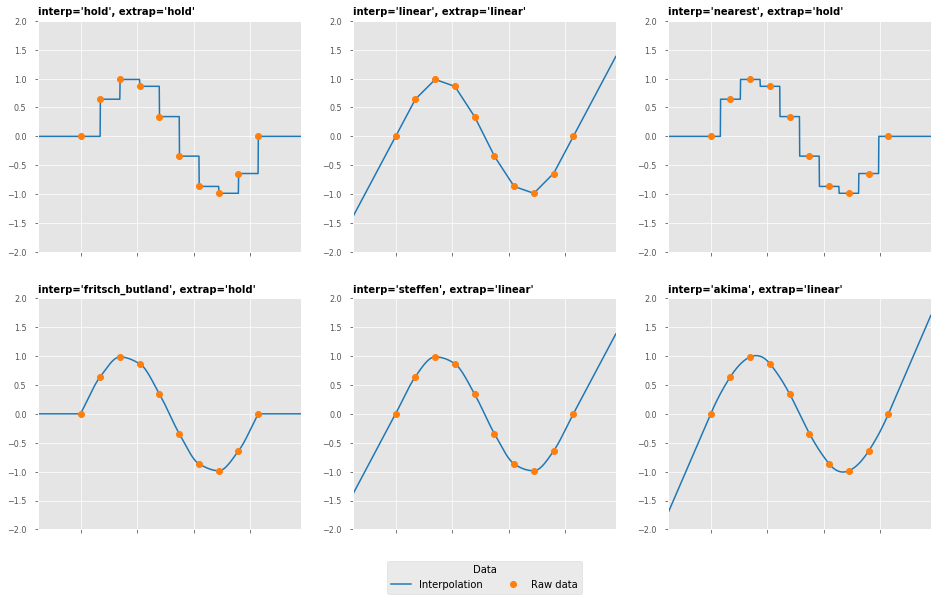

In [83]:
import matplotlib as mpl
from matplotlib.figure import SubplotParams

x = np.linspace(0, 2 * np.pi, 10)
y = np.sin(x)
xi = np.linspace(-1.5,  2 * np.pi + 1.5, 1000)
dxi = np.ones_like(xi)

m2d = xr.DataArray(data=y, coords=[('x', x)])

methods = [('hold', 'hold'),
           ('linear', 'linear'), 
           ('nearest', 'hold'),
           ('fritsch_butland', 'hold'), 
           ('steffen', 'linear'), 
           ('akima', 'linear')]

with plt.style.context('ggplot'):
    mpl.rc('axes', prop_cycle=mpl.cycler('color', mpl.cm.get_cmap("tab10").colors))
    fig = plt.figure(figsize=(16,9),
                     subplotpars=SubplotParams(top=0.91, hspace=0.2))

    for i, method in enumerate(methods):
        ax = fig.add_subplot(2, 3, i + 1,
                             title=f"interp='{method[0]}', extrap='{method[1]}'",
                             xlim=[-1.5, 2 * np.pi + 1.5], ylim=[-2, 2], label="what"
                             )
        ax.title.set_position((0, 1))
        ax.title.set_horizontalalignment('left')
        ax.title.set_fontsize(10)
        ax.title.set_fontweight('bold')
        ax.xaxis.units = 'V'
        ax.xaxis.name = 'Tension'
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.tick_params("y", labelsize=8)
        
        yi = m2d(xi, interp=method[0], extrap=method[1])       
        ax.plot(xi, yi, m2d.x, m2d.data, 'o')
        
    plt.gcf().axes[4].legend(["Interpolation", "Raw data"], bbox_to_anchor=(0, -0.3, 1., 0.1),
               loc=8, ncol=2, mode="normal", borderaxespad=0.5, title="Data")

# micro bench on 2D-array

In [58]:
res = {'xarray': [], 'c_sdf' : []}
x = np.logspace(1, 4, num=10, dtype=np.int16)
for size in x:
    new_tension = arr.tension[0].data + np.random.random_sample(size=size) * (arr.tension[-1].data - arr.tension[0].data)
    new_resistance = arr.resistance[0].data + np.random.random_sample(size=size) * (arr.resistance[-1].data - arr.resistance[0].data)

    interp_xr = %timeit -qo arr.interp({'tension': new_tension, 'resistance': new_resistance})
    res['xarray'].append(interp_xr)
    
    interp_c_sdf = %timeit -qo arr(new_tension, new_resistance)
    res['c_sdf'].append(interp_c_sdf)

In [59]:
res

{'xarray': [<TimeitResult : 6.46 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
  <TimeitResult : 6.46 ms ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
  <TimeitResult : 6.99 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
  <TimeitResult : 8.91 ms ± 52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
  <TimeitResult : 19.8 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
  <TimeitResult : 112 ms ± 638 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>,
  <TimeitResult : 584 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
  <TimeitResult : 2.63 s ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
  <TimeitResult : 15.5 s ± 147 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
  <TimeitResult : 2min 23s ± 18.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>],
 'c_sdf': [<TimeitResult : 1.08 ms ± 7.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops

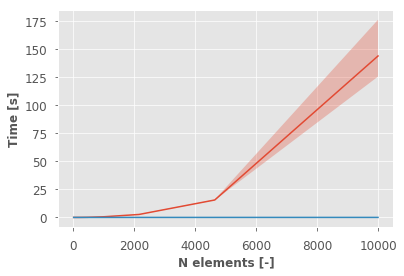

In [72]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    fig.add_subplot(111, xlabel="N elements [-]", ylabel="Time [s]")
    
    plt.plot(x, [t.average for t in res['xarray']])
    plt.fill_between(x, [t.best for t in res['xarray']], [t.worst for t in res['xarray']], alpha=0.3)
    
    plt.plot(x, [t.average for t in res['c_sdf']])
    plt.fill_between(x, [t.best for t in res['c_sdf']], [t.worst for t in res['c_sdf']], alpha=0.3)